# Papers:
https://arxiv.org/pdf/2410.02857v1 

https://arxiv.org/abs/2111.01713

# Imports

In [1]:
#
# !pip install torch torchvision einops tqdm wandb pickle5 numpy
import pickle
import wandb

# Original Imports
import math
import copy
import torch
from torch import nn, einsum
import torch.nn.functional as F
from inspect import isfunction
from functools import partial

from torch.utils import data
from pathlib import Path
from torch.optim import Adam
from torchvision import transforms, utils
from PIL import Image

import numpy as np
from tqdm import tqdm
from einops import rearrange

from time import time

# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#
wandb.login(key="YOUR KEY HERE")  


Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nlevi/.netrc
wandb: Currently logged in as: noamlevi (rmt-ml) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Config

In [2]:
#
# --- Configuration ---

# W&B Project Name
WANDB_PROJECT_NAME = "flamingo-ddpm"

# Dataset
DATASET_PATH = './data/flamingo.pkl' # <-- IMPORTANT: Point this to your pickle file

IMAGE_SIZE = 128         # Image resolution (must be a power of 2)
CHANNELS = 4             # Number of image channels

# Training
TRAIN_NUM_STEPS = 100000     # Total number of training steps
TRAIN_BATCH_SIZE = 32        # Batch size
LEARNING_RATE = 1e-4       # Learning rate
GRADIENT_ACCUMULATE_EVERY = 2 # Gradient accumulation steps

# Model
UNET_DIM = 64            # Base dimension for the U-Net
UNET_DIM_MULTS = (1, 2, 4, 8) # Multipliers for U-Net dimensions

# Diffusion
TIMESTEPS = 1000             # Number of diffusion timesteps

# Checkpointing and Logging
CHECKPOINTS_TO_SAVE = 10     # How many checkpoints to save during training
SAVE_EVERY = TRAIN_NUM_STEPS // CHECKPOINTS_TO_SAVE # Automatically calculate save interval
SAMPLE_EVERY = TRAIN_NUM_STEPS // CHECKPOINTS_TO_SAVE # Also sample images at each save
LOG_DIR = './results'        # Directory to save models and samples

# EMA (Exponential Moving Average)
EMA_DECAY = 0.995
STEP_START_EMA = 2000
UPDATE_EMA_EVERY = 10

# Multi-GPU (if available)
# List the IDs of the GPUs you want to use. E.g., [0] for one GPU, [0, 1] for two.
GPU_IDS = [0]

# Helper Functions

In [3]:
#
#   _   _      _
#  | | | | ___| |_ __   ___ _ __ ___
#  | |_| |/ _ \ | '_ \ / _ \ '__/ __|
#  |  _  |  __/ | |_) |  __/ |  \__ \
#  |_| |_|\___|_| .__/ \___|_|  |___/
#               |_|

def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose2d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Rezero(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        self.g = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.fn(x) * self.g

# Building Blocks
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim_out, 3, padding=1),
            nn.GroupNorm(groups, dim_out),
            Mish()
        )
    def forward(self, x):
        return self.block(x)

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            Mish(),
            nn.Linear(time_emb_dim, dim_out)
        )

        self.block1 = Block(dim, dim_out)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        h = self.block1(x)
        h += self.mlp(time_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)

# Unet Model

In [4]:
#
#   _   _            _                         _      _
#  | | | |_ __   ___| |_   _ __ ___   ___   __| | ___| |
#  | | | | '_ \ / _ \ __| | '_ ` _ \ / _ \ / _` |/ _ \ |
#  | |_| | | | |  __/ |_  | | | | | | (_) | (_| |  __/ |
#   \___/|_| |_|\___|\__| |_| |_| |_|\___/ \__,_|\___|_|
#
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        out_dim = None,
        dim_mults=(1, 2, 4, 8),
        channels = 3
    ):
        super().__init__()
        self.channels = channels

        dims = [channels, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        self.time_pos_emb = SinusoidalPosEmb(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            Mish(),
            nn.Linear(dim * 4, dim)
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_out, time_emb_dim = dim),
                ResnetBlock(dim_out, dim_out, time_emb_dim = dim),
                Residual(Rezero(LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim = dim)
        self.mid_attn = Residual(Rezero(LinearAttention(mid_dim)))
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim = dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(nn.ModuleList([
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim = dim),
                ResnetBlock(dim_in, dim_in, time_emb_dim = dim),
                Residual(Rezero(LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else nn.Identity()
            ]))

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            Block(dim, dim),
            nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        t = self.time_pos_emb(time)
        t = self.mlp(t)

        h = []

        for resnet, resnet2, attn, downsample in self.downs:
            x = resnet(x, t)
            x = resnet2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for resnet, resnet2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, t)
            x = resnet2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)


#    ____                     _                   _ _  __  __           _
#   / ___| __ _ _   _ ___ ___(_) __ _ _ __     __| (_)/ _|/ _|_   _ ___(_) ___  _ __
#  | |  _ / _` | | | / __/ __| |/ _` | '_ \   / _` | | |_| |_| | | / __| |/ _ \| '_ \
#  | |_| | (_| | |_| \__ \__ \ | (_| | | | | | (_| | |  _|  _| |_| \__ \ | (_) | | | |
#   \____|\__,_|\__,_|___/___/_|\__,_|_| |_|  \__,_|_|_| |_|  \__,_|___/_|\___/|_| |_|
#

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

def cosine_beta_schedule(timesteps, s = 0.008):
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, a_min = 0, a_max = 0.999)

class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        *,
        image_size,
        channels = 3,
        timesteps = 1000,
        loss_type = 'l1',
        betas = None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn

        if betas is not None:
            betas = betas.detach().cpu().numpy() if isinstance(betas, torch.Tensor) else betas
        else:
            betas = cosine_beta_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1. - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(x, t=t, noise=self.denoise_fn(x, t))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape):
        device = self.betas.device
        b = shape[0]
        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size))

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, noise = None):
        b, c, h, w = x_start.shape
        noise = default(noise, lambda: torch.randn_like(x_start))

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_recon = self.denoise_fn(x_noisy, t)

        if self.loss_type == 'l1':
            loss = (noise - x_recon).abs().mean()
        elif self.loss_type == 'l2':
            loss = F.mse_loss(noise, x_recon)
        else:
            raise NotImplementedError()

        return loss

    def forward(self, x, *args, **kwargs):
        b, c, h, w, device = *x.shape, x.device
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()
        return self.p_losses(x, t, *args, **kwargs)

    @torch.no_grad()
    def p_sample_loop_from_t(self, x_noisy, start_t):
        """
        Starts the denoising loop from a specific timestep `start_t`
        with a given noisy image `x_noisy`.
        """
        device = self.betas.device
        b = x_noisy.shape[0]
        img = x_noisy

        # The loop now starts from `start_t` and goes down to 0
        for i in tqdm(reversed(range(0, start_t)), desc=f'sampling loop from t={start_t}', total=start_t):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))
        return img

# Dataset Class

In [5]:
#
#   ____        _                 _          _
#  |  _ \  __ _| |_ __ _ ___  ___| |_    ___| | __ _ ___ ___
#  | | | |/ _` | __/ _` / __|/ _ \ __|  / __| |/ _` / __/ __|
#  | |_| | (_| | || (_| \__ \  __/ |_  | (__| | (_| \__ \__ \
#  |____/ \__,_|\__\__,_|___/\___|\__|  \___|_|\__,_|___/___/
#

class FlamingoDataset(data.Dataset):
    def __init__(self, file_path, image_size):
        super().__init__()
        self.image_size = image_size
        
        print(f"Loading dataset from {file_path}...")
        with open(file_path, 'rb') as file:
            # Assuming the pickle file contains a tuple (labels, images)
            _, images = pickle.load(file)
        
        self.images = images
        # We will normalize to [-1, 1] after converting to tensor
        self.min_val = np.min(self.images)
        self.max_val = np.max(self.images)
        print(f"Dataset loaded. Original shape: {self.images.shape}. Min: {self.min_val}, Max: {self.max_val}")

        # --- NEW: Create a transform to resize the images ---
        self.transform = transforms.Compose([
            transforms.ToTensor(), # Converts numpy array (H, W, C) or (C, H, W) to tensor (C, H, W) and scales to [0.0, 1.0]
            transforms.Resize(image_size, antialias=True),
            transforms.Lambda(lambda t: (t * 2) - 1) # Manually scale from [0, 1] to [-1, 1]
        ])
        
    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):
        # Get image as numpy array, original shape is (C, H, W) -> (4, 100, 100)
        img_np = self.images[index].astype(np.float32)
    
        # --- FIX: Transpose from (C, H, W) to (H, W, C) for ToTensor ---
        # transforms.ToTensor() expects a numpy array in (Height, Width, Channels) format.
        img_np = img_np.transpose((1, 2, 0)) # New shape: (100, 100, 4)
        
        # Apply the transformations. 
        # ToTensor will convert it back to (C, H, W) tensor and scale to [0, 1].
        # Resize will then make it (C, 128, 128).
        img_tensor = self.transform(img_np)
        
        # Data Augmentation (on tensor)
        if torch.rand(1) < 0.5:
            img_tensor = transforms.functional.hflip(img_tensor)
        if torch.rand(1) < 0.5:
            img_tensor = transforms.functional.vflip(img_tensor)
    
        return img_tensor

# Trainer Class

In [6]:
#
#   _____          _                        _
#  |_   _| __ __ _(_)_ __   ___ _ __    ___| | __ _ ___ ___
#    | || '__/ _` | | '_ \ / _ \ '__|  / __| |/ _` / __/ __|
#    | || | | (_| | | | | |  __/ |    | (__| | (_| \__ \__ \
#    |_||_|  \__,_|_|_| |_|\___|_|     \___|_|\__,_|___/___/
#

class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        dataset, # <-- Takes the dataset object directly
        *,
        train_batch_size,
        train_lr,
        train_num_steps,
        gradient_accumulate_every,
        ema_decay,
        step_start_ema,
        update_ema_every,
        save_every,
        sample_every,
        logdir,
        rank = [0],
        num_workers = 0,
    ):
        super().__init__()
        self.model = torch.nn.DataParallel(diffusion_model, device_ids=rank)
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(self.model)
        self.update_ema_every = update_ema_every

        self.step_start_ema = step_start_ema
        self.save_every = save_every
        self.sample_every = sample_every

        self.batch_size = train_batch_size
        self.image_size = diffusion_model.image_size
        self.gradient_accumulate_every = gradient_accumulate_every
        self.train_num_steps = train_num_steps

        self.logdir = Path(logdir)
        self.logdir.mkdir(exist_ok = True)
        
        # Use the passed dataset
        self.ds = dataset
        self.dl = cycle(data.DataLoader(self.ds, batch_size = train_batch_size, shuffle=True, pin_memory=True, num_workers=num_workers))
        self.opt = Adam(diffusion_model.parameters(), lr=train_lr)

        self.step = 0
        self.reset_parameters()

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())

    def step_ema(self):
        if self.step < self.step_start_ema:
            self.reset_parameters()
            return
        self.ema.update_model_average(self.ema_model, self.model)

    def save(self, milestone):
        data = {
            'step': self.step,
            'model': self.model.state_dict(),
            'ema': self.ema_model.state_dict()
        }
        torch.save(data, str(self.logdir / f'model-{milestone:06d}.pt'))

    def load(self, milestone):
        data = torch.load(str(self.logdir / f'model-{milestone:06d}.pt'))
        self.step = data['step']
        self.model.load_state_dict(data['model'])
        self.ema_model.load_state_dict(data['ema'])

    def train(self):
        t1 = time()
        while self.step < self.train_num_steps:
            for i in range(self.gradient_accumulate_every):
                data = next(self.dl).to(device=DEVICE)
                
                loss = self.model(data).sum()
                (loss / self.gradient_accumulate_every).backward()

            t0 = time()
            print(f'Step: {self.step} | Loss: {loss.item():.4f} | Time since last step: {t0 - t1:.3f}s')
            
            # --- W&B Logging ---
            wandb.log({
                'step': self.step,
                'loss': loss.item(),
                'time_per_step': t0 - t1,
            })
            t1 = time()
            
            self.opt.step()
            self.opt.zero_grad()

            if self.step % self.update_ema_every == 0:
                self.step_ema()

            if self.step != 0 and self.step % self.save_every == 0:
                self.save(self.step)
                print(f"Checkpoint saved at step {self.step}")

            if self.step != 0 and self.step % self.sample_every == 0:
                milestone = self.step // self.sample_every
                batches = num_to_groups(16, self.batch_size) # Generate 16 sample images
                all_images_list = list(map(lambda n: self.ema_model.module.sample(batch_size=n), batches))
                
                all_images = torch.cat(all_images_list, dim=0)
                # Denormalize from [-1, 1] to [0, 1] for saving
                all_images = (all_images + 1) * 0.5
                
                # We have 4 channels, but save_image works best with 3 (RGB) or 1 (grayscale).
                # We'll save the first 3 channels as an example.
                utils.save_image(all_images[:, :3, :, :], str(self.logdir / f'sample-{self.step:06d}.png'), nrow = 4)
                print(f"Sample images saved at step {self.step}")
                
                # --- W&B Image Logging ---
                wandb.log({
                    "samples": [wandb.Image(img) for img in all_images[:, :3, :, :]]
                })

            self.step += 1

        print('Training complete.')

# Run training

In [14]:
#
# --- Main Training ---

# 1. Initialize W&B
wandb.init(
    project=WANDB_PROJECT_NAME,
    config={
        "image_size": IMAGE_SIZE,
        "channels": CHANNELS,
        "unet_dim": UNET_DIM,
        "unet_dim_mults": UNET_DIM_MULTS,
        "batch_size": TRAIN_BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "train_steps": TRAIN_NUM_STEPS,
    }
)

# 2. Instantiate the model and diffusion process
model = Unet(
    dim = UNET_DIM,
    dim_mults = UNET_DIM_MULTS,
    channels = CHANNELS
)

diffusion = GaussianDiffusion(
    model,
    image_size = IMAGE_SIZE,
    timesteps = TIMESTEPS,
    channels = CHANNELS,
    loss_type = 'l1'
).to(DEVICE)

# 3. Create the dataset
dataset = FlamingoDataset(
    file_path=DATASET_PATH,
    image_size=IMAGE_SIZE
)

# 4. Instantiate the Trainer
trainer = Trainer(
    diffusion,
    dataset,
    train_batch_size = TRAIN_BATCH_SIZE,
    train_lr = LEARNING_RATE,
    train_num_steps = TRAIN_NUM_STEPS,
    gradient_accumulate_every = GRADIENT_ACCUMULATE_EVERY,
    ema_decay = EMA_DECAY,
    step_start_ema = STEP_START_EMA,
    update_ema_every = UPDATE_EMA_EVERY,
    save_every = SAVE_EVERY,
    sample_every = SAMPLE_EVERY,
    logdir = LOG_DIR,
    rank = GPU_IDS,
)

# 5. Start training
trainer.train()

# 6. Finish the W&B run
wandb.finish()

Loading dataset from ./data/flamingo.pkl...
Dataset loaded. Original shape: (5000, 4, 100, 100). Min: 0.0, Max: 1.0
Step: 0 | Loss: 0.8546 | Time since last step: 1.438s
Step: 1 | Loss: 0.8190 | Time since last step: 0.470s
Step: 2 | Loss: 0.8039 | Time since last step: 0.124s
Step: 3 | Loss: 0.7981 | Time since last step: 0.124s
Step: 4 | Loss: 0.7960 | Time since last step: 0.126s
Step: 5 | Loss: 0.7927 | Time since last step: 0.124s
Step: 6 | Loss: 0.7917 | Time since last step: 0.125s
Step: 7 | Loss: 0.7911 | Time since last step: 0.124s
Step: 8 | Loss: 0.7903 | Time since last step: 0.124s
Step: 9 | Loss: 0.7865 | Time since last step: 0.126s
Step: 10 | Loss: 0.7839 | Time since last step: 0.124s
Step: 11 | Loss: 0.7829 | Time since last step: 0.130s
Step: 12 | Loss: 0.7776 | Time since last step: 0.124s
Step: 13 | Loss: 0.7738 | Time since last step: 0.125s
Step: 14 | Loss: 0.7678 | Time since last step: 0.125s
Step: 15 | Loss: 0.7613 | Time since last step: 0.124s
Step: 16 | Los

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.29it/s]


Sample images saved at step 10000
Step: 10001 | Loss: 0.0221 | Time since last step: 20.716s
Step: 10002 | Loss: 0.0207 | Time since last step: 0.126s
Step: 10003 | Loss: 0.0256 | Time since last step: 0.125s
Step: 10004 | Loss: 0.0240 | Time since last step: 0.124s
Step: 10005 | Loss: 0.0210 | Time since last step: 0.125s
Step: 10006 | Loss: 0.0209 | Time since last step: 0.125s
Step: 10007 | Loss: 0.0220 | Time since last step: 0.124s
Step: 10008 | Loss: 0.0276 | Time since last step: 0.125s
Step: 10009 | Loss: 0.0224 | Time since last step: 0.125s
Step: 10010 | Loss: 0.0171 | Time since last step: 0.126s
Step: 10011 | Loss: 0.0188 | Time since last step: 0.131s
Step: 10012 | Loss: 0.0223 | Time since last step: 0.124s
Step: 10013 | Loss: 0.0279 | Time since last step: 0.125s
Step: 10014 | Loss: 0.0236 | Time since last step: 0.125s
Step: 10015 | Loss: 0.0238 | Time since last step: 0.124s
Step: 10016 | Loss: 0.0146 | Time since last step: 0.124s
Step: 10017 | Loss: 0.0213 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Sample images saved at step 20000
Step: 20001 | Loss: 0.0277 | Time since last step: 14.464s
Step: 20002 | Loss: 0.0161 | Time since last step: 0.211s
Step: 20003 | Loss: 0.0175 | Time since last step: 0.125s
Step: 20004 | Loss: 0.0262 | Time since last step: 0.124s
Step: 20005 | Loss: 0.0232 | Time since last step: 0.124s
Step: 20006 | Loss: 0.0141 | Time since last step: 0.124s
Step: 20007 | Loss: 0.0170 | Time since last step: 0.124s
Step: 20008 | Loss: 0.0218 | Time since last step: 0.124s
Step: 20009 | Loss: 0.0284 | Time since last step: 0.124s
Step: 20010 | Loss: 0.0249 | Time since last step: 0.124s
Step: 20011 | Loss: 0.0244 | Time since last step: 0.129s
Step: 20012 | Loss: 0.0153 | Time since last step: 0.124s
Step: 20013 | Loss: 0.0193 | Time since last step: 0.124s
Step: 20014 | Loss: 0.0205 | Time since last step: 0.124s
Step: 20015 | Loss: 0.0256 | Time since last step: 0.124s
Step: 20016 | Loss: 0.0249 | Time since last step: 0.124s
Step: 20017 | Loss: 0.0224 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Sample images saved at step 30000
Step: 30001 | Loss: 0.0185 | Time since last step: 14.578s
Step: 30002 | Loss: 0.0204 | Time since last step: 0.125s
Step: 30003 | Loss: 0.0218 | Time since last step: 0.125s
Step: 30004 | Loss: 0.0191 | Time since last step: 0.125s
Step: 30005 | Loss: 0.0209 | Time since last step: 0.125s
Step: 30006 | Loss: 0.0300 | Time since last step: 0.124s
Step: 30007 | Loss: 0.0219 | Time since last step: 0.125s
Step: 30008 | Loss: 0.0190 | Time since last step: 0.125s
Step: 30009 | Loss: 0.0155 | Time since last step: 0.125s
Step: 30010 | Loss: 0.0243 | Time since last step: 0.125s
Step: 30011 | Loss: 0.0191 | Time since last step: 0.129s
Step: 30012 | Loss: 0.0196 | Time since last step: 0.125s
Step: 30013 | Loss: 0.0185 | Time since last step: 0.125s
Step: 30014 | Loss: 0.0175 | Time since last step: 0.125s
Step: 30015 | Loss: 0.0195 | Time since last step: 0.125s
Step: 30016 | Loss: 0.0172 | Time since last step: 0.124s
Step: 30017 | Loss: 0.0217 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Sample images saved at step 40000
Step: 40001 | Loss: 0.0120 | Time since last step: 14.383s
Step: 40002 | Loss: 0.0203 | Time since last step: 0.124s
Step: 40003 | Loss: 0.0274 | Time since last step: 0.124s
Step: 40004 | Loss: 0.0174 | Time since last step: 0.123s
Step: 40005 | Loss: 0.0208 | Time since last step: 0.123s
Step: 40006 | Loss: 0.0208 | Time since last step: 0.124s
Step: 40007 | Loss: 0.0153 | Time since last step: 0.123s
Step: 40008 | Loss: 0.0189 | Time since last step: 0.123s
Step: 40009 | Loss: 0.0258 | Time since last step: 0.123s
Step: 40010 | Loss: 0.0164 | Time since last step: 0.123s
Step: 40011 | Loss: 0.0197 | Time since last step: 0.128s
Step: 40012 | Loss: 0.0283 | Time since last step: 0.267s
Step: 40013 | Loss: 0.0175 | Time since last step: 0.123s
Step: 40014 | Loss: 0.0253 | Time since last step: 0.123s
Step: 40015 | Loss: 0.0161 | Time since last step: 0.124s
Step: 40016 | Loss: 0.0233 | Time since last step: 0.123s
Step: 40017 | Loss: 0.0156 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Sample images saved at step 50000
Step: 50001 | Loss: 0.0175 | Time since last step: 14.379s
Step: 50002 | Loss: 0.0225 | Time since last step: 0.124s
Step: 50003 | Loss: 0.0164 | Time since last step: 0.124s
Step: 50004 | Loss: 0.0212 | Time since last step: 0.072s
Step: 50005 | Loss: 0.0162 | Time since last step: 0.124s
Step: 50006 | Loss: 0.0224 | Time since last step: 0.124s
Step: 50007 | Loss: 0.0163 | Time since last step: 0.123s
Step: 50008 | Loss: 0.0182 | Time since last step: 0.124s
Step: 50009 | Loss: 0.0147 | Time since last step: 0.124s
Step: 50010 | Loss: 0.0172 | Time since last step: 0.123s
Step: 50011 | Loss: 0.0150 | Time since last step: 0.128s
Step: 50012 | Loss: 0.0175 | Time since last step: 0.124s
Step: 50013 | Loss: 0.0244 | Time since last step: 0.123s
Step: 50014 | Loss: 0.0192 | Time since last step: 0.123s
Step: 50015 | Loss: 0.0210 | Time since last step: 0.123s
Step: 50016 | Loss: 0.0236 | Time since last step: 0.124s
Step: 50017 | Loss: 0.0150 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.35it/s]


Sample images saved at step 60000
Step: 60001 | Loss: 0.0141 | Time since last step: 14.428s
Step: 60002 | Loss: 0.0181 | Time since last step: 0.124s
Step: 60003 | Loss: 0.0198 | Time since last step: 0.124s
Step: 60004 | Loss: 0.0227 | Time since last step: 0.124s
Step: 60005 | Loss: 0.0196 | Time since last step: 0.124s
Step: 60006 | Loss: 0.0152 | Time since last step: 0.124s
Step: 60007 | Loss: 0.0221 | Time since last step: 0.124s
Step: 60008 | Loss: 0.0188 | Time since last step: 0.124s
Step: 60009 | Loss: 0.0222 | Time since last step: 0.124s
Step: 60010 | Loss: 0.0185 | Time since last step: 0.124s
Step: 60011 | Loss: 0.0227 | Time since last step: 0.128s
Step: 60012 | Loss: 0.0146 | Time since last step: 0.124s
Step: 60013 | Loss: 0.0140 | Time since last step: 0.124s
Step: 60014 | Loss: 0.0143 | Time since last step: 0.124s
Step: 60015 | Loss: 0.0181 | Time since last step: 0.124s
Step: 60016 | Loss: 0.0149 | Time since last step: 0.124s
Step: 60017 | Loss: 0.0189 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Sample images saved at step 70000
Step: 70001 | Loss: 0.0186 | Time since last step: 14.506s
Step: 70002 | Loss: 0.0244 | Time since last step: 0.124s
Step: 70003 | Loss: 0.0257 | Time since last step: 0.123s
Step: 70004 | Loss: 0.0209 | Time since last step: 0.124s
Step: 70005 | Loss: 0.0272 | Time since last step: 0.126s
Step: 70006 | Loss: 0.0201 | Time since last step: 0.126s
Step: 70007 | Loss: 0.0139 | Time since last step: 0.126s
Step: 70008 | Loss: 0.0217 | Time since last step: 0.126s
Step: 70009 | Loss: 0.0123 | Time since last step: 0.125s
Step: 70010 | Loss: 0.0169 | Time since last step: 0.125s
Step: 70011 | Loss: 0.0168 | Time since last step: 0.132s
Step: 70012 | Loss: 0.0161 | Time since last step: 0.124s
Step: 70013 | Loss: 0.0157 | Time since last step: 0.123s
Step: 70014 | Loss: 0.0151 | Time since last step: 0.123s
Step: 70015 | Loss: 0.0175 | Time since last step: 0.124s
Step: 70016 | Loss: 0.0166 | Time since last step: 0.125s
Step: 70017 | Loss: 0.0236 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Sample images saved at step 80000
Step: 80001 | Loss: 0.0175 | Time since last step: 14.528s
Step: 80002 | Loss: 0.0171 | Time since last step: 0.124s
Step: 80003 | Loss: 0.0190 | Time since last step: 0.123s
Step: 80004 | Loss: 0.0229 | Time since last step: 0.123s
Step: 80005 | Loss: 0.0252 | Time since last step: 0.124s
Step: 80006 | Loss: 0.0135 | Time since last step: 0.123s
Step: 80007 | Loss: 0.0174 | Time since last step: 0.123s
Step: 80008 | Loss: 0.0218 | Time since last step: 0.123s
Step: 80009 | Loss: 0.0162 | Time since last step: 0.123s
Step: 80010 | Loss: 0.0157 | Time since last step: 0.123s
Step: 80011 | Loss: 0.0159 | Time since last step: 0.128s
Step: 80012 | Loss: 0.0189 | Time since last step: 0.123s
Step: 80013 | Loss: 0.0235 | Time since last step: 0.123s
Step: 80014 | Loss: 0.0172 | Time since last step: 0.123s
Step: 80015 | Loss: 0.0223 | Time since last step: 0.123s
Step: 80016 | Loss: 0.0203 | Time since last step: 0.124s
Step: 80017 | Loss: 0.0189 | Time sin

sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Sample images saved at step 90000
Step: 90001 | Loss: 0.0253 | Time since last step: 14.650s
Step: 90002 | Loss: 0.0212 | Time since last step: 0.124s
Step: 90003 | Loss: 0.0148 | Time since last step: 0.124s
Step: 90004 | Loss: 0.0240 | Time since last step: 0.124s
Step: 90005 | Loss: 0.0237 | Time since last step: 0.123s
Step: 90006 | Loss: 0.0139 | Time since last step: 0.123s
Step: 90007 | Loss: 0.0168 | Time since last step: 0.123s
Step: 90008 | Loss: 0.0137 | Time since last step: 0.123s
Step: 90009 | Loss: 0.0140 | Time since last step: 0.124s
Step: 90010 | Loss: 0.0192 | Time since last step: 0.123s
Step: 90011 | Loss: 0.0154 | Time since last step: 0.128s
Step: 90012 | Loss: 0.0220 | Time since last step: 0.123s
Step: 90013 | Loss: 0.0221 | Time since last step: 0.123s
Step: 90014 | Loss: 0.0169 | Time since last step: 0.124s
Step: 90015 | Loss: 0.0163 | Time since last step: 0.123s
Step: 90016 | Loss: 0.0198 | Time since last step: 0.123s
Step: 90017 | Loss: 0.0147 | Time sin

Loading checkpoint from: ./results/model-090000.pt


/tmp/1015701/ipykernel_3107845/2500830067.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(CHECKPOINT_PATH)


Generating 16 images...


sampling loop time step: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 153.88it/s]


Samples saved to 'final_samples.png'


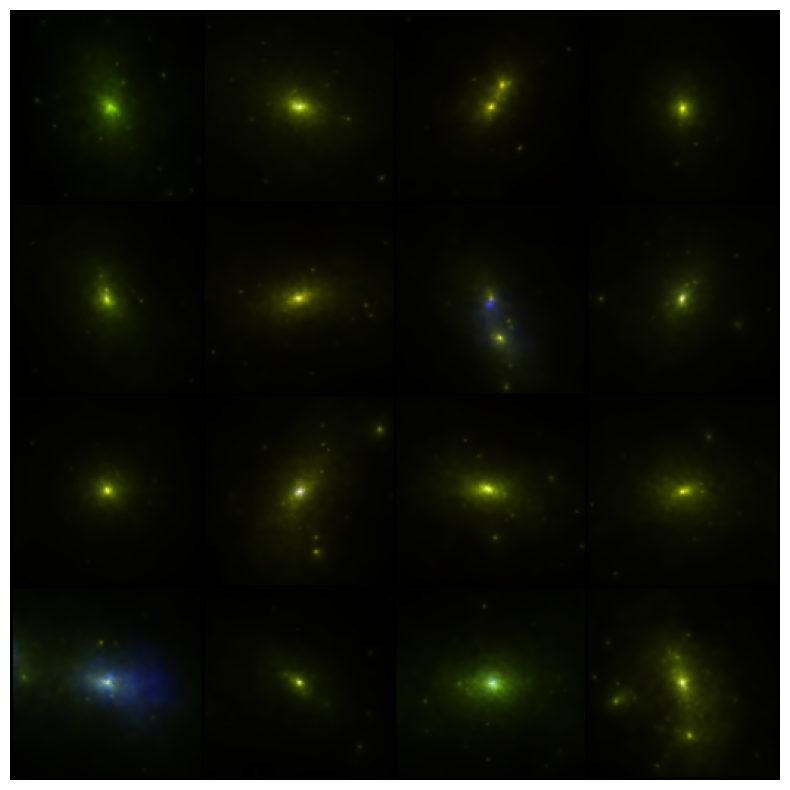

In [22]:
#
# --- Sampling from a Trained Model ---

# Path to your saved checkpoint

# model-090000
CHECKPOINT_PATH = f"{LOG_DIR}/model-{'090000'}.pt" # Path to the final checkpoint
NUM_SAMPLES = 16
SAMPLING_BATCH_SIZE = 4

# 1. Re-create the model and diffusion instances with the same parameters as training
model_sample = Unet(
    dim = UNET_DIM,
    dim_mults = UNET_DIM_MULTS,
    channels = CHANNELS
)

diffusion_sample = GaussianDiffusion(
    model_sample,
    image_size = IMAGE_SIZE,
    timesteps = TIMESTEPS,
    channels = CHANNELS,
    loss_type = 'l1'
).to(DEVICE)

# Wrap in DataParallel to match the saved state_dict keys
ema_model_sample = torch.nn.DataParallel(diffusion_sample, device_ids=GPU_IDS)

# 2. Load the checkpoint
print(f"Loading checkpoint from: {CHECKPOINT_PATH}")
data = torch.load(CHECKPOINT_PATH)
ema_model_sample.load_state_dict(data['ema'])

# 3. Sample images
print(f"Generating {NUM_SAMPLES} images...")
batches = num_to_groups(NUM_SAMPLES, SAMPLING_BATCH_SIZE)
all_images_list = list(map(lambda n: ema_model_sample.module.sample(batch_size=n), batches))
generated_images = torch.cat(all_images_list, dim=0)

# 4. Denormalize and save/display
generated_images = (generated_images + 1) * 0.5 # from [-1, 1] to [0, 1]

# Save the first 3 channels of the generated images
utils.save_image(generated_images[:,:3,:,:], str(Path(LOG_DIR) / 'final_samples.png'), nrow=4)
print("Samples saved to 'final_samples.png'")

# Optional: Display in notebook if you have matplotlib
try:
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid
    
    grid = make_grid(generated_images[:,:3,:,:], nrow=4).cpu()
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
except ImportError:
    print("Matplotlib not found. Cannot display images in notebook.")

# FID score analysis

Preparing real images directory for FID...
Loading dataset from ./data/flamingo.pkl...
Dataset loaded. Original shape: (5000, 4, 100, 100). Min: 0.0, Max: 1.0
Saved 1024 images to ./fid_real_images

--- Processing checkpoint: model-010000.pt ---


/tmp/1017135/ipykernel_1769124/1115188656.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(ckpt_path)


Generating 1024 samples for step 10000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...


/home/nlevi/Noam/miniconda3/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


Step: 10000, FID: 66.7701

--- Processing checkpoint: model-020000.pt ---
Generating 1024 samples for step 20000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 20000, FID: 34.5262

--- Processing checkpoint: model-030000.pt ---
Generating 1024 samples for step 30000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 30000, FID: 31.9349

--- Processing checkpoint: model-040000.pt ---
Generating 1024 samples for step 40000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 40000, FID: 30.8101

--- Processing checkpoint: model-050000.pt ---
Generating 1024 samples for step 50000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 50000, FID: 27.8162

--- Processing checkpoint: model-060000.pt ---
Generating 1024 samples for step 60000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 60000, FID: 27.9479

--- Processing checkpoint: model-070000.pt ---
Generating 1024 samples for step 70000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 70000, FID: 29.3160

--- Processing checkpoint: model-080000.pt ---
Generating 1024 samples for step 80000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 80000, FID: 28.6195

--- Processing checkpoint: model-090000.pt ---
Generating 1024 samples for step 90000...


sampling loop time step: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.94it/s]


Saved 1024 images to ./fid_generated_images
Calculating FID score...
Step: 90000, FID: 28.6419


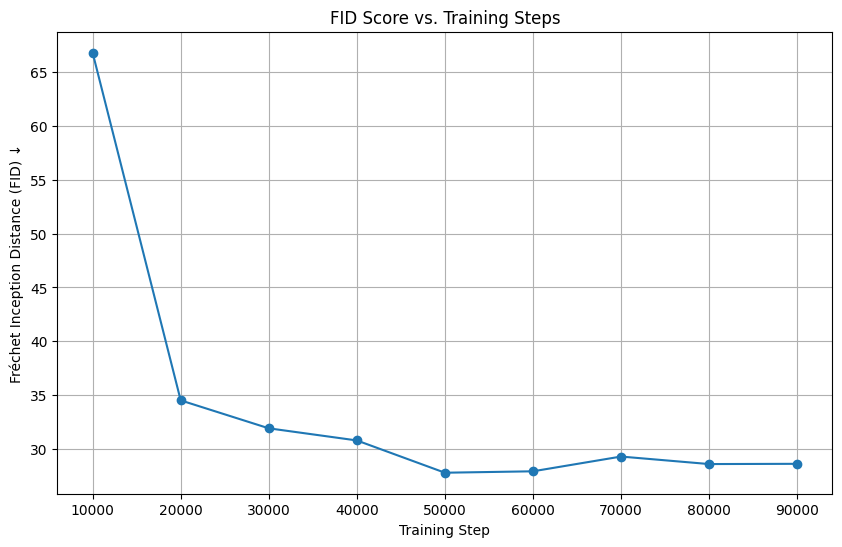

FID plot saved to results/fid_over_time.png


In [7]:
# --- FID ANALYSIS SCRIPT ---

import torch
import torch_fidelity
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import utils
import re # For extracting step number from filename

# --- Configuration ---
LOG_DIR = './results'
REAL_IMAGES_DIR = './fid_real_images'
GENERATED_IMAGES_DIR = './fid_generated_images'
NUM_SAMPLES_FOR_FID = 1024 # A reasonable number for FID calculation
FID_BATCH_SIZE = 64 # Batch size for generating images

# --- Helper Function to Prepare Image Directories ---

def prepare_image_directory(directory_path, images_tensor):
    """Saves a batch of image tensors to a directory for FID calculation."""
    path = Path(directory_path)
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True)
    
    # Denormalize from [-1, 1] to [0, 1]
    images_tensor = (images_tensor + 1) * 0.5
    
    # Save each image individually
    for i, img in enumerate(images_tensor):
        # FID's Inception model needs 3 channels (RGB)
        # We take the first 3 channels.
        utils.save_image(img[:3, :, :], path / f'image_{i:04d}.png')
    print(f"Saved {len(images_tensor)} images to {directory_path}")


# --- Main FID Calculation Loop ---

def calculate_fid_over_checkpoints():
    # 1. Prepare the directory of REAL images from the training set
    print("Preparing real images directory for FID...")
    real_dataset = FlamingoDataset(file_path=DATASET_PATH, image_size=IMAGE_SIZE)
    # Get a subset of real images for comparison
    real_images = torch.stack([real_dataset[i] for i in range(NUM_SAMPLES_FOR_FID)])
    prepare_image_directory(REAL_IMAGES_DIR, real_images)

    # 2. Setup the model architecture (it needs to be instantiated before loading state_dict)
    model_fid = Unet(dim=UNET_DIM, dim_mults=UNET_DIM_MULTS, channels=CHANNELS)
    diffusion_fid = GaussianDiffusion(
        model_fid, image_size=IMAGE_SIZE, timesteps=TIMESTEPS, channels=CHANNELS
    ).to(DEVICE)
    ema_model_fid = torch.nn.DataParallel(diffusion_fid, device_ids=GPU_IDS)

    # 3. Find all checkpoints
    log_path = Path(LOG_DIR)
    checkpoints = sorted(list(log_path.glob('model-*.pt')))
    
    if not checkpoints:
        print(f"No checkpoints found in {LOG_DIR}. Exiting.")
        return

    fid_scores = []

    # 4. Loop through each checkpoint
    for ckpt_path in checkpoints:
        print(f"\n--- Processing checkpoint: {ckpt_path.name} ---")
        
        # Load the EMA weights from the checkpoint
        data = torch.load(ckpt_path)
        step = data['step']
        ema_model_fid.load_state_dict(data['ema'])
        
        # Generate samples
        print(f"Generating {NUM_SAMPLES_FOR_FID} samples for step {step}...")
        batches = num_to_groups(NUM_SAMPLES_FOR_FID, FID_BATCH_SIZE)
        all_images_list = list(map(lambda n: ema_model_fid.module.sample(batch_size=n), batches))
        generated_images = torch.cat(all_images_list, dim=0)
        
        # Save generated samples to a temporary directory
        prepare_image_directory(GENERATED_IMAGES_DIR, generated_images)

        # Calculate FID
        print("Calculating FID score...")
        try:
            metrics_dict = torch_fidelity.calculate_metrics(
                input1=REAL_IMAGES_DIR,
                input2=GENERATED_IMAGES_DIR,
                cuda=torch.cuda.is_available(),
                fid=True,
                verbose=False
            )
            fid = metrics_dict['frechet_inception_distance']
            fid_scores.append((step, fid))
            print(f"Step: {step}, FID: {fid:.4f}")
        except Exception as e:
            print(f"Could not calculate FID for step {step}. Error: {e}")
        
    # Clean up the temporary generated images directory
    if Path(GENERATED_IMAGES_DIR).exists():
        shutil.rmtree(GENERATED_IMAGES_DIR)

    # 5. Plot the results
    if fid_scores:
        steps, fids = zip(*sorted(fid_scores))
        plt.figure(figsize=(10, 6))
        plt.plot(steps, fids, marker='o', linestyle='-')
        plt.title('FID Score vs. Training Steps')
        plt.xlabel('Training Step')
        plt.ylabel('Fréchet Inception Distance (FID) ↓')
        plt.grid(True)
        plt.savefig(log_path / 'fid_over_time.png')
        plt.show()
        print(f"FID plot saved to {log_path / 'fid_over_time.png'}")

# --- Run the analysis ---
calculate_fid_over_checkpoints()

# Forward Backward Experiments

Loading checkpoint: ./results/model-080000.pt


/tmp/1015701/ipykernel_3107845/3789852768.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(CHECKPOINT_PATH)


Loading dataset from ./data/flamingo.pkl...
Dataset loaded. Original shape: (5000, 4, 100, 100). Min: 0.0, Max: 1.0
Adding noise corresponding to t=800
Denoising the image from the noised state...


sampling loop from t=800: 100%|█████████████████████████████████████████████████████████████████████| 800/800 [00:05<00:00, 159.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5198147..2.2773628].



--- Patch Comparison Results ---
Total patches: 1024
Patches changed (L1 diff > 0.1): 132
Percentage changed: 12.89%


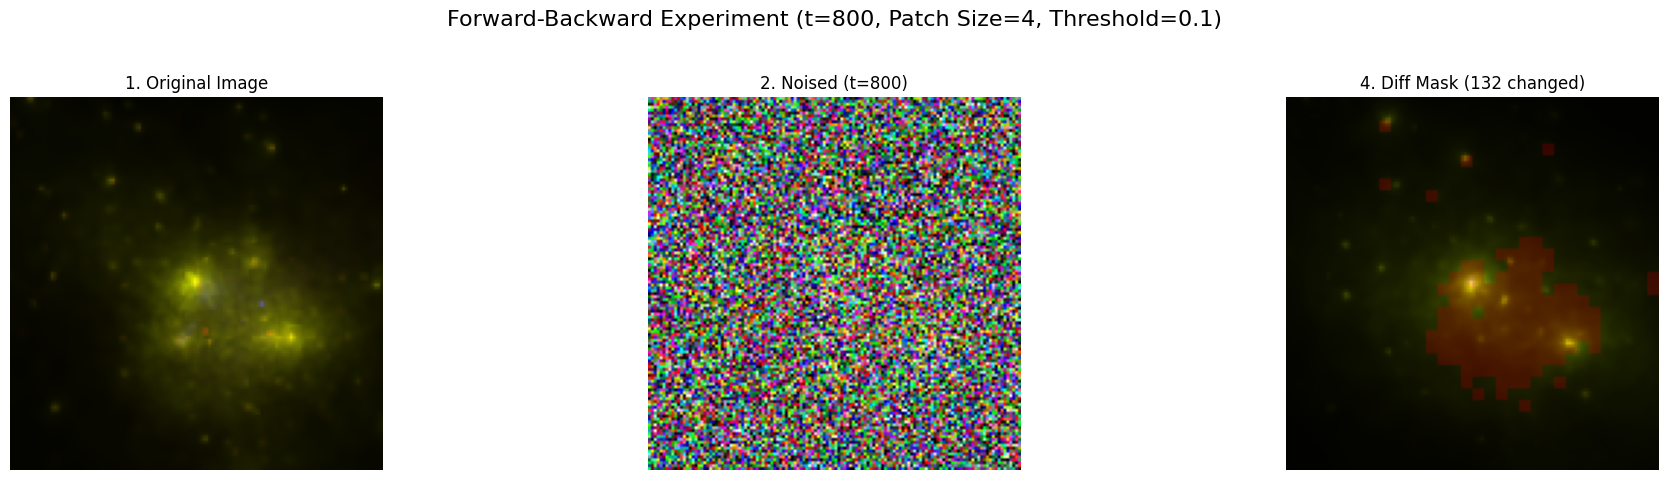

In [75]:
# --- FORWARD-BACKWARD ANALYSIS SCRIPT ---
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from einops import rearrange, repeat

# --- Configuration ---
CHECKPOINT_PATH = f"{LOG_DIR}/model-{'080000'}.pt" # <-- Point to your best checkpoint
IMAGE_INDEX_TO_TEST = 4  # Which image from the dataset to use
NOISE_TIMESTEP = 800      # How much noise to add (0 to 999)
PATCH_SIZE = 4           # Size of patches for comparison (128 is divisible by 16)
CHANGE_THRESHOLD = 0.1    # L1 difference threshold to consider a patch "changed"

# Ensure the main script's classes and functions are defined or imported
# (Unet, GaussianDiffusion, FlamingoDataset)

# --- Main Experiment Function ---

def forward_backward_experiment():
    # 1. Load the model
    print(f"Loading checkpoint: {CHECKPOINT_PATH}")
    model_exp = Unet(dim=UNET_DIM, dim_mults=UNET_DIM_MULTS, channels=CHANNELS)
    diffusion_exp = GaussianDiffusion(
        model_exp, image_size=IMAGE_SIZE, timesteps=TIMESTEPS, channels=CHANNELS
    ).to(DEVICE)
    ema_model_exp = torch.nn.DataParallel(diffusion_exp, device_ids=GPU_IDS)
    data = torch.load(CHECKPOINT_PATH)
    ema_model_exp.load_state_dict(data['ema'])
    
    # We need the diffusion module itself for the methods
    diffusion_module = ema_model_exp.module

    # 2. Get a clean image from the dataset
    dataset_exp = FlamingoDataset(file_path=DATASET_PATH, image_size=IMAGE_SIZE)
    original_img = dataset_exp[IMAGE_INDEX_TO_TEST].unsqueeze(0).to(DEVICE) # Add batch dim

    # 3. Forward process: add noise
    print(f"Adding noise corresponding to t={NOISE_TIMESTEP}")
    t = torch.tensor([NOISE_TIMESTEP], device=DEVICE).long()
    # Use q_sample to add noise to the original image
    noised_img = diffusion_module.q_sample(x_start=original_img, t=t)

    # 4. Backward process: denoise the image
    print("Denoising the image from the noised state...")
    # Use our new method to denoise from the specific timestep
    denoised_img = diffusion_module.p_sample_loop_from_t(
        x_noisy=noised_img,
        start_t=NOISE_TIMESTEP
    )

    # 5. Compare original vs. denoised using patches
    h = w = PATCH_SIZE
    # Rearrange images into a batch of patches
    # Shape: (b, c, h, w) -> (num_patches, c, ph, pw)
    original_patches = rearrange(original_img, 'b c (p1 h) (p2 w) -> (b p1 p2) c h w', h=h, w=w)
    denoised_patches = rearrange(denoised_img, 'b c (p1 h) (p2 w) -> (b p1 p2) c h w', h=h, w=w)
    
    # Calculate L1 difference for each patch (mean absolute difference)
    patch_diffs = (original_patches - denoised_patches).abs().mean(dim=[1, 2, 3])
    
    num_patches = patch_diffs.shape[0]
    changed_patches_mask = (patch_diffs > CHANGE_THRESHOLD)
    num_changed = changed_patches_mask.sum().item()
    
    print(f"\n--- Patch Comparison Results ---")
    print(f"Total patches: {num_patches}")
    print(f"Patches changed (L1 diff > {CHANGE_THRESHOLD}): {num_changed}")
    print(f"Percentage changed: {100 * num_changed / num_patches:.2f}%")
    
    # 6. Visualization
    # Create a "diff mask" image to highlight changed patches
    diff_mask_patches = torch.ones_like(original_patches)
    # Color changed patches red, keep unchanged patches from original
    red_patch = torch.tensor([1.0, -1.0, -1.0], device=DEVICE).view(1, 3, 1, 1) # Red in [-1,1] space
    for i, changed in enumerate(changed_patches_mask):
        if changed:
            # We only color the first 3 channels (RGB)
            diff_mask_patches[i, :3, :, :] = red_patch
        else:
            diff_mask_patches[i] = original_patches[i] # Keep original content
            
    # Rearrange patches back into a full image
    num_h_patches = IMAGE_SIZE // PATCH_SIZE
    diff_mask_img = rearrange(diff_mask_patches, '(p1 p2) c h w -> c (p1 h) (p2 w)', p1=num_h_patches)

    # Convert tensors to CPU and [0, 1] for plotting
    def prep_for_plot(img_tensor):
        # Select RGB, move to CPU, denormalize, permute for matplotlib
        return (img_tensor[0, :3].cpu() + 1) / 2.0
    
    original_plot = prep_for_plot(original_img).permute(1, 2, 0)
    noised_plot = prep_for_plot(noised_img).permute(1, 2, 0)
    denoised_plot = prep_for_plot(denoised_img).permute(1, 2, 0)
    diff_mask_plot = (diff_mask_img[:3,:,:].cpu() + 1) / 2.0
    diff_mask_plot = diff_mask_plot.permute(1, 2, 0)

    # Plot everything
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Forward-Backward Experiment (t={NOISE_TIMESTEP}, Patch Size={PATCH_SIZE}, Threshold={CHANGE_THRESHOLD})", fontsize=16)

    axs[0].imshow(original_plot)
    axs[0].set_title('1. Original Image')
    axs[0].axis('off')

    axs[1].imshow(noised_plot)
    axs[1].set_title(f'2. Noised (t={NOISE_TIMESTEP})')
    axs[1].axis('off')

    axs[2].imshow(denoised_plot)
    axs[2].set_title('3. Denoised Image')
    axs[2].axis('off')
    
    axs[2].imshow(diff_mask_plot, alpha = 0.2)
    axs[2].set_title(f'4. Diff Mask ({num_changed} changed)')
    axs[2].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(Path(LOG_DIR) / f'forward_backward_t{NOISE_TIMESTEP}.png')
    plt.show()

    return original_img, noised_img, denoised_img

# --- Run the experiment ---
original_img, noised_img, denoised_img = forward_backward_experiment()

In [54]:
torch.mean(torch.abs(original_img))
# torch.max(original_img)

tensor(0.9160, device='cuda:0')

In [55]:
44/64

0.6875

In [65]:
128 * 128/ (4*4)

1024.0